In [2]:
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
import data_gen

# Gaussian Process Regression

A Gaussian process builds a surrogate model for a model too expensive to call loads of times. It extends a multivariate Gaussian to infinite dimensions, meaning random variables $x$ becomes random functions $f(x)$. The mean of the variables $\mu$ becomes a mean function $m(x)$ and rather than a covariance matrix $\Sigma_{ij}$ we have a covariance function $\textbf{k}(x_i, x_j)$.
### Covariance functions
There are quite a few covariance functions, but the one we'll use is the squared exponential covariance function - RBFs - 
$$
k(\textbf{x}, \textbf{x'}) = v\text{exp}\left[-\frac{1}{2} \sum^d_{i=1} \frac{(x_i-x_i')^2}{\ell^2_i} \right],
$$
where $v,\ell_i >0, i=1, ..., d$ are hyperparameters. <br>
For each of these covariance functions, $v$ is known as the $\textbf{signal variance}$ or $\textbf{signal strength}$. The bigger it is, the more the GP $f(x)$ will vary about the mean.

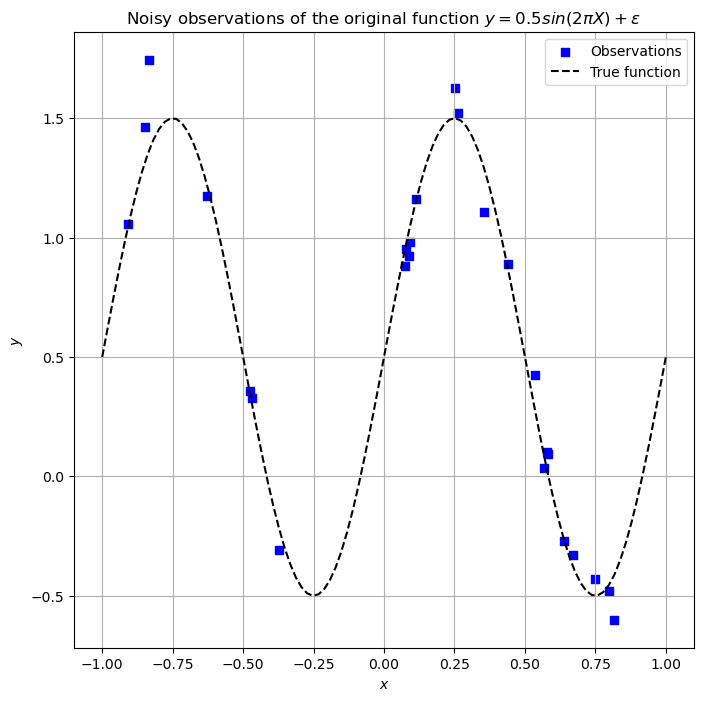

In [173]:
N = 100
lb = -1
ub = 1
X_true = np.linspace(lb, ub, N)
num_obvs = 25
sigma = 0.1
X_data = np.random.uniform(lb, ub, num_obvs)
y_data = data_gen.data(X_data, sigma**2)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_data, y_data, marker='s', label='Observations', color="b")
ax.plot(X_true, data_gen.sinusoid(X_true), label='True function', color="k", linestyle='--')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title("Noisy observations of the original function $y = 0.5 sin(2\pi X) + \epsilon$")
ax.legend()
ax.grid(True)

#### Define Squared Exponential Covariance Kernel

In [193]:
class SquaredExponentialKernel:
    def __init__(self, length_scale=1, v=1):
        self.length_scale = length_scale
        self.v = v
    def __call__(self, arg1, arg2):
        return float(self.v * np.exp(-np.linalg.norm(arg1 - arg2)**2 / (2*self.length_scale**2)))

#### Make function to form a covariance matrix

In [194]:
def build_covariance_matrix(x0, x1, covariance_function):
    return np.array([[covariance_function(a, b) for a in x0] for b in x1])

### Build GP

In [195]:
class GPR:
    def __init__(self, X_data, y_data, sigma=0, covariance_function=SquaredExponentialKernel()):
        self.X_data = X_data
        self.y_data = y_data
        self.sigma = sigma
        self.covariance_function = covariance_function
        
        self.K_inv = np.linalg.inv(build_covariance_matrix(X_data, X_data, covariance_function) + (sigma**2 + 1e-7)*np.eye(len(X_data))) 
        
    def predict(self, X_test):
        K_star = build_covariance_matrix(self.X_data, X_test, self.covariance_function)
        K_star_star = build_covariance_matrix(X_test, X_test, self.covariance_function)
        
        test_mean = np.dot(K_star, np.dot(self.y_data, self.K_inv.T).T).flatten()
        
        test_covariance_matrix = K_star_star - np.dot(
            K_star, 
            np.dot(
                self.K_inv,
                K_star.T
            )
        )
        variance = np.diag(test_covariance_matrix)
        
        return test_mean, test_covariance_matrix, variance

In [196]:
num_test = 15

X_test = np.random.uniform(lb, ub, num_test)
y_test = data_gen.data(X_test, sigma**2)

ls = 0.11
v = 0.1

# Initialise GP
GP = GPR(X_data, y_data, sigma, covariance_function=SquaredExponentialKernel(length_scale=ls, v=v))
mean, cov_matrix, variance = GP.predict(X_test)
std = np.sqrt(variance)

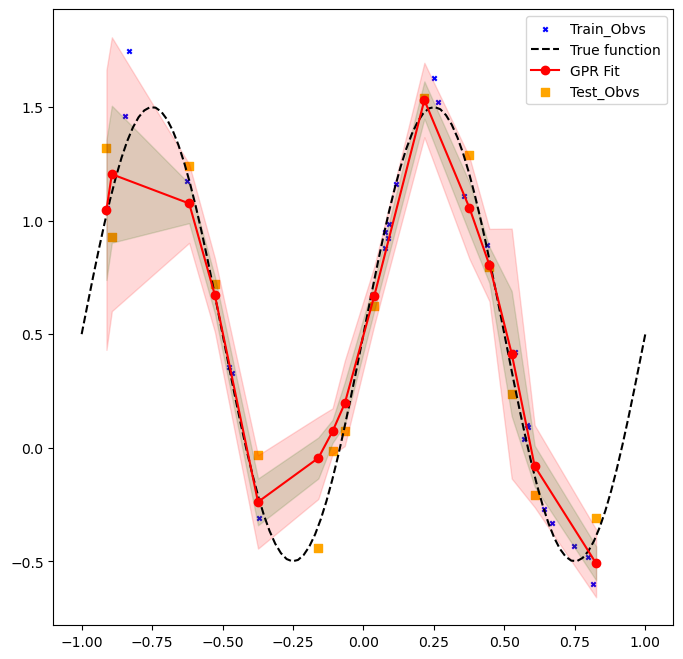

In [198]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_data, y_data, marker='x', label='Train_Obvs', color="b", s=10)
ax.plot(X_true, data_gen.sinusoid(X_true), label='True function', color="k", linestyle='--')

sorted_indices = np.argsort(X_test)
X_test = X_test[sorted_indices]
y_test = y_test[sorted_indices]
mean = mean[sorted_indices]
ax.plot(X_test, mean, '-o', label="GPR Fit", color="r")
ax.scatter(X_test, y_test, marker='s', label='Test_Obvs', color="orange")

err1_lower = mean - std*1
err1_upper = mean + std*1

err2_lower = mean - std*2
err2_upper = mean + std*2
ax.fill_between(X_test, err1_lower, err1_upper, alpha=0.15, color='g')
ax.fill_between(X_test, err2_lower, err2_upper, alpha=0.15, color='r')
ax.legend()